# Weight truncation in UniFold

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Generic imports
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import tensorflow as tf

### Custom functions
from omnifold import *
from omnifold.utilities import *

In [3]:
! nvidia-smi -L # list GPUs available

GPU 0: Quadro RTX 6000 (UUID: GPU-26dfa6b3-88ef-1e87-ba91-3ca0255166ab)
GPU 1: Quadro RTX 6000 (UUID: GPU-2c315734-0ffc-e8d8-40fb-29a2ccd25ab5)
GPU 2: Quadro RTX 6000 (UUID: GPU-057fcb77-7816-2825-8db8-b78905930b06)
GPU 3: Quadro RTX 6000 (UUID: GPU-dc56feb4-523f-6ded-e577-4416c9dc6561)


In [4]:
### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-11-10 16:50:28.140120: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-10 16:50:28.167014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-11-10 16:50:28.167187: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-10 16:50:28.168813: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-10 16:50:28.170629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-11-10 16:50:28.170872: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [5]:
plot_setup()
plt.rcParams.update({"font.family": "serif",})

In [6]:
plot_dir = './plots/'

### Load files

Since we're not using data yet, "MC" = Powheg + Pythia8 MC16e and "data" = Sherpa 2.2.1 MC16e.

In [7]:
folder = './omnifold_data/'
f_mc = uproot.open(folder+"ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root")
f_data = uproot.open(folder+"ZjetOmnifold_Jun25_Sherpa221_mc16e_slim.root")

In [8]:
columns = f_mc['OmniTree'].keys()

These columns are the same for both samples, since they're both MC:

In [9]:
f_mc['OmniTree'].keys() == f_data['OmniTree'].keys()

True

Note that variables ending in `_tracks` require MultiIndex-ing. It's possible to combine these with flat variables, but it does increase the size of the DataFrame considerably, so let's ignore the MultiIndex variables for now. 

In [10]:
mc = f_mc['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

data = f_data['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

print("MC has {:,} events with {} columns.".format(mc.shape[0],mc.shape[1]))
print("Data has {:,} events with {} columns.".format(data.shape[0],data.shape[1]))

MC has 416,725 events with 57 columns.
Data has 3,578,623 events with 57 columns.


### Apply event selection

In [11]:
mc['pass190'] = mc['pass190'].astype('bool')
mc['truth_pass190'] = mc['truth_pass190'].astype('bool')
data['pass190'] = data['pass190'].astype('bool')
data['truth_pass190'] = data['truth_pass190'].astype('bool')

The sample we're using already has these cuts applied, but we'll keep them in for future datasets. 

In [12]:
mc = mc[(mc.pass190 | mc.truth_pass190)]
data = data[data.pass190]
data_truth = data[data.truth_pass190]

Normalize the weights:

In [13]:
for weights in [mc.weight_mc, mc.weight, data_truth.weight_mc, data.weight]:
    weights /= np.mean(weights)

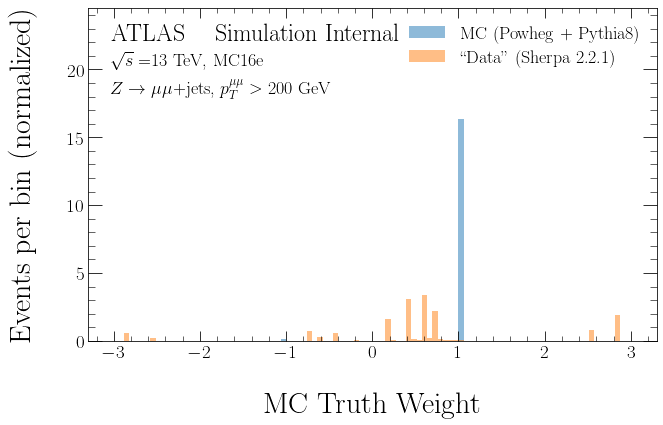

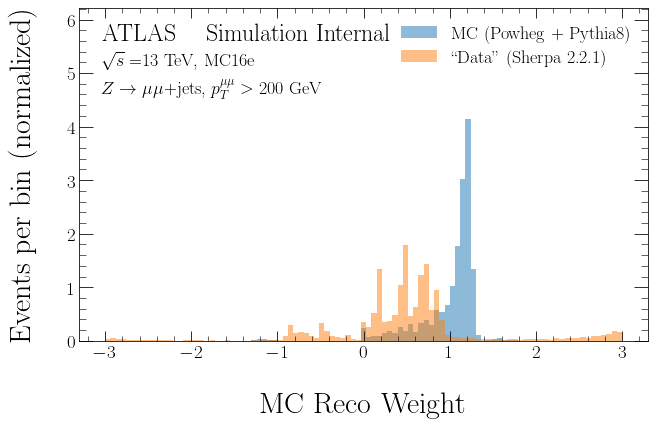

In [14]:
bins = np.linspace(-3, 3, 100)

plt.figure(figsize=(10, 6))
hW_sim_truth, _, _ = plt.hist(mc.weight_mc,
                              bins=bins,
                              label=r'MC (Powheg + Pythia8)',
                              **plot_style_2)
hW_data_truth, _, _ = plt.hist(data_truth.weight_mc,
                               bins=bins,
                               label=r'``Data" (Sherpa 2.2.1)',
                               **plot_style_2)
plt.xlabel('MC Truth Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_truth, hW_data_truth)))
plt.legend()
draw_atlas_text()
plt.show()

plt.figure(figsize=(10, 6))
hW_sim_reco, _, _ = plt.hist(mc.weight,
                             bins=bins,
                             label=r'MC (Powheg + Pythia8)',
                             **plot_style_2)
hW_data_reco, _, _ = plt.hist(data.weight,
                              bins=bins,
                              label=r'``Data" (Sherpa 2.2.1)',
                              **plot_style_2)
plt.xlabel('MC Reco Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_reco, hW_data_reco)))
plt.legend()
draw_atlas_text()
plt.show()

### Load IBU histograms to get binning

In [15]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]
plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

IBU_hists = uproot.open(folder+'unfoldingPlotsJune14_UnfoldedHists.root')

bins = []
for label in file_labels:
    bins += [IBU_hists['SherpaUnfoldWPythia_2018_'+label].to_numpy()[1]]
    
labels_and_bins = zip(file_labels, plot_labels, bins)

ibu_hists = []
for file_label, plot_label, plot_bins in labels_and_bins:
    ibu_hists += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

In [16]:
### Replace bins with Laura's new binning! 
ibu_hists[0]['bins'] = np.array([1, 7, 11, 15, 20, 30, 40]) # leading jet n_charged_tracks
ibu_hists[4]['bins'] = np.array([0,  50,  100,  150,  200,  300,  1000]) # leading jet pT
ibu_hists[10]['bins'] = np.array([0,  0.05,  0.1,  0.17,  0.25,  0.35,  0.5,  0.9]) # leading jet tau_1

# UniFold

### Apply unfolding

In [17]:
K.clear_session()

In [18]:
i = 0 # index of variable of interest (0 = n_tracks for leading jet)

In [19]:
save_label0 = 'example'
bins = ibu_hists[i]['bins']
x_label = ibu_hists[i]['plot_label']
file_label = ibu_hists[i]['file_label']
os.makedirs(plot_dir+'UniFold/'+file_label, exist_ok=True)
save_label = plot_dir+'UniFold/'+file_label+'/'+save_label0
print("Saving as {}.".format(save_label))

Saving as ./plots/UniFold/Ntracks_trackj1/example.


Grab the particular variable you care about, and set a dummy value for events that don't pass each MC selection:

In [20]:
dummyval = -99
mc['truth_var'] = np.where(mc.truth_pass190, mc['truth_'+file_label], dummyval)
mc['reco_var'] = np.where(mc.pass190, mc[file_label], dummyval)
data_truth['truth_var'] = data_truth['truth_'+file_label]
data['reco_var'] = data[file_label]

/tmp/ipykernel_11191/2058628029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_truth['truth_var'] = data_truth['truth_'+file_label]


In [21]:
# # artificially shift MC distribution to induce infinite weights
# offset = 30
# mc.truth_var += offset
# # mc.reco_var += offset

In [22]:
# mc.truth_var.replace(dummyval+offset, dummyval, inplace=True)

Plot this observable in MC & "data" before unfolding:

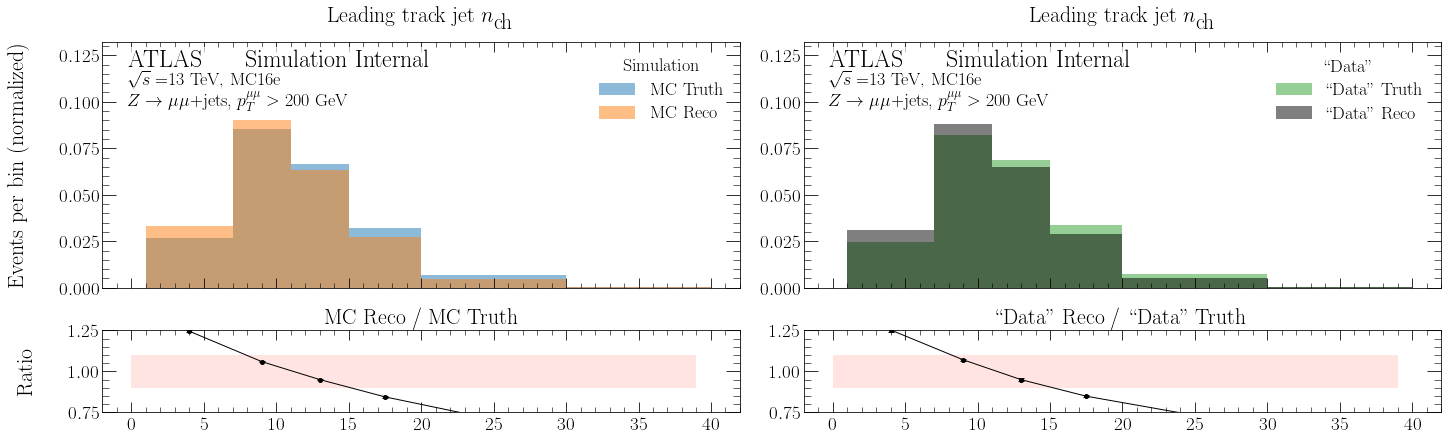

In [23]:
### Add in 200 GeV cuts for plotting only 
mc_plots = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
data_truth_plots = data_truth[data_truth.truth_pT_ll > 200]
data_plots = data[data.pT_ll > 200]

omnifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_plots))) # the right size for the 200 GeV cut

plot_distributions(
    sim_truth=mc_plots.truth_var,
    sim_reco=mc_plots.reco_var,
    sim_truth_weights_MC=mc_plots.weight_mc,
    sim_reco_weights_MC=mc_plots.weight,
    data_truth=data_truth_plots.truth_var,
    data_reco=data_plots.reco_var,
    data_truth_weights_MC=data_truth_plots.weight_mc,
    data_reco_weights_MC=data_plots.weight,
    bins=bins,
    x_label=x_label,
    save_label=save_label
)

Standardize the data by z-score:

In [24]:
mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc.truth_var), np.array(mc.reco_var), np.array(data.reco_var))

Unfold!

In [25]:
weights, _ = unifold(iterations=1,
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc.weight_mc,
                     sim_reco_weights_MC=mc.weight,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data.weight,
                     dummyval=dummyval,
                     verbose=1,
                    )

2021-11-10 16:51:22.607194: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-11-10 16:51:22.615798: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994280000 Hz
2021-11-10 16:51:22.617113: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5567427d4a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-10 16:51:22.617141: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-10 16:51:22.726202: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556714e5dbb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-11-10 16:51:22.726253: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2021-11-10 16:51:22.727883: I 


ITERATION: 1

STEP 1

Epoch 1/1000
  1/245 [..............................] - ETA: 0s - loss: 0.7143 - accuracy: 0.0590

2021-11-10 16:51:23.626487: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


245/245 [==============================] - 1s 3ms/step - loss: 0.3779 - accuracy: 0.4452 - val_loss: 0.3362 - val_accuracy: 0.4474
Epoch 2/1000
245/245 [==============================] - 1s 2ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3361 - val_accuracy: 0.4474
Epoch 3/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3361 - val_accuracy: 0.4474
Epoch 4/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3361 - val_accuracy: 0.4474
Epoch 5/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3362 - val_accuracy: 0.4474
Epoch 6/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3361 - val_accuracy: 0.4474
Epoch 7/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.4472 - val_loss: 0.3362 - val_accuracy: 0.4474
Epoch

/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/unifold.py:16: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)



STEP 1b

Epoch 1/1000
49/49 [==============================] - 0s 4ms/step - loss: 1.5971 - accuracy: 0.2501 - val_loss: 1.5985 - val_accuracy: 0.2497
Epoch 2/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5970 - accuracy: 0.2501 - val_loss: 1.5980 - val_accuracy: 0.2497
Epoch 3/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5970 - accuracy: 0.2501 - val_loss: 1.5980 - val_accuracy: 0.2497
Epoch 4/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5970 - accuracy: 0.2501 - val_loss: 1.5981 - val_accuracy: 0.2497
Epoch 5/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5969 - accuracy: 0.2501 - val_loss: 1.5981 - val_accuracy: 0.2497
Epoch 6/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5969 - accuracy: 0.2501 - val_loss: 1.5981 - val_accuracy: 0.2497
Epoch 7/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5970 - accuracy: 0.2501 - val_loss: 1.5982 - val_accuracy: 0.2

/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/unifold.py:218: RuntimeWarning: invalid value encountered in true_divide
  weights_pull /= np.mean(weights_pull)


60/60 [==============================] - 0s 4ms/step - loss: 0.5494 - accuracy: 0.3099 - val_loss: 0.1973 - val_accuracy: 0.5000
Epoch 2/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.0520 - accuracy: 0.5000 - val_loss: 0.0053 - val_accuracy: 0.5000
Epoch 3/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 0.5000 - val_loss: 0.0015 - val_accuracy: 0.5000
Epoch 4/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.5000 - val_loss: 7.7432e-04 - val_accuracy: 0.5000
Epoch 5/1000
60/60 [==============================] - 0s 3ms/step - loss: 6.0172e-04 - accuracy: 0.5000 - val_loss: 4.6709e-04 - val_accuracy: 0.5000
Epoch 6/1000
60/60 [==============================] - 0s 3ms/step - loss: 3.8198e-04 - accuracy: 0.5000 - val_loss: 3.1269e-04 - val_accuracy: 0.5000
Epoch 7/1000
60/60 [==============================] - 0s 4ms/step - loss: 2.6429e-04 - accuracy: 0.5000 - val_loss: 2.2403e-04 - val_accuracy

100%|██████████| 1/1 [00:37<00:00, 37.69s/it]


In [26]:
weights.shape # (n_iterations, n_steps, n_events)

(1, 2, 416725)

In [27]:
print(weights.min())
print(weights.max())

nan
nan


In [28]:
weights

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.09786743e-03, 2.50738580e-04, 8.07316527e-02, ...,
         3.50104213e-01, 1.09917164e+00, 1.25059311e-03]]])

In [29]:
weights[:,0] # step 1 weights for each iteration

array([[0., 0., 0., ..., 0., 0., 0.]])

In [31]:
np.isnan(weights[0,0]).sum()

4

In [32]:
len(weights[0,0])

416725

In [30]:
# fraction of NaN weights for step 1, iteration 1
100*np.isnan(weights[0,0]).sum()/len(weights[0,0])

0.0009598656188133662

In [33]:
weights[:,1] # step 2 weights for each iteration

array([[2.09786743e-03, 2.50738580e-04, 8.07316527e-02, ...,
        3.50104213e-01, 1.09917164e+00, 1.25059311e-03]])

In [34]:
# fraction of NaN weights for step 1, iteration 1
100*np.isnan(weights[0,1]).sum()/len(weights[0,1])

0.0

In [35]:
np.isnan(weights[0,1]).sum()

0

In [37]:
# fraction of weights that are NaNs
np.isnan(weights).sum()/(weights.shape[0]*weights.shape[1]*weights.shape[2])

4.7993280940668305e-06

In [38]:
# fraction of weights that are non-NaN
np.count_nonzero(~np.isnan(weights))/(weights.shape[0]*weights.shape[1]*weights.shape[2])

0.999995200671906

In [39]:
array = weights[:,1].flatten()

In [40]:
array

array([2.09786743e-03, 2.50738580e-04, 8.07316527e-02, ...,
       3.50104213e-01, 1.09917164e+00, 1.25059311e-03])

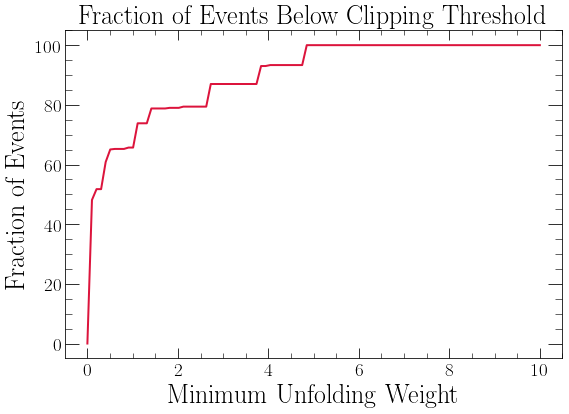

In [41]:
fractions = []
for x in np.linspace(0,10,100): 
    fractions.append(100*(array < x).sum()/len(array))
    
plt.plot(np.linspace(0,10,100),fractions, linewidth=2, color='crimson')
plt.title("Fraction of Events Below Clipping Threshold", fontsize=26)
plt.xlabel("Minimum Unfolding Weight", fontsize=26, labelpad=5)
plt.ylabel("Fraction of Events", fontsize=26, labelpad=5);

Store the weights for the dataset that passes 200 GeV:

In [42]:
filter = (mc.truth_pT_ll > 200) | (mc.pT_ll > 200)

omnifold_weights[i] = best_1D_reweighting(
    test=mc_plots.reco_var,
    test_weights=np.array(mc_plots.weight) * weights[:,:,filter][:,1],
    target=data_plots.reco_var,
    target_weights=data_plots.weight,
    bins=bins)

In [43]:
omnifold_weights[i].min()

-6.867618288895073

In [44]:
omnifold_weights[i].max()

12.682093135285186

  0%|          | 0/1 [00:00<?, ?it/s]/clusterfs/ml4hep/mpettee/miniconda3/envs/omnifold/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: Axis limits cannot be NaN or Inf

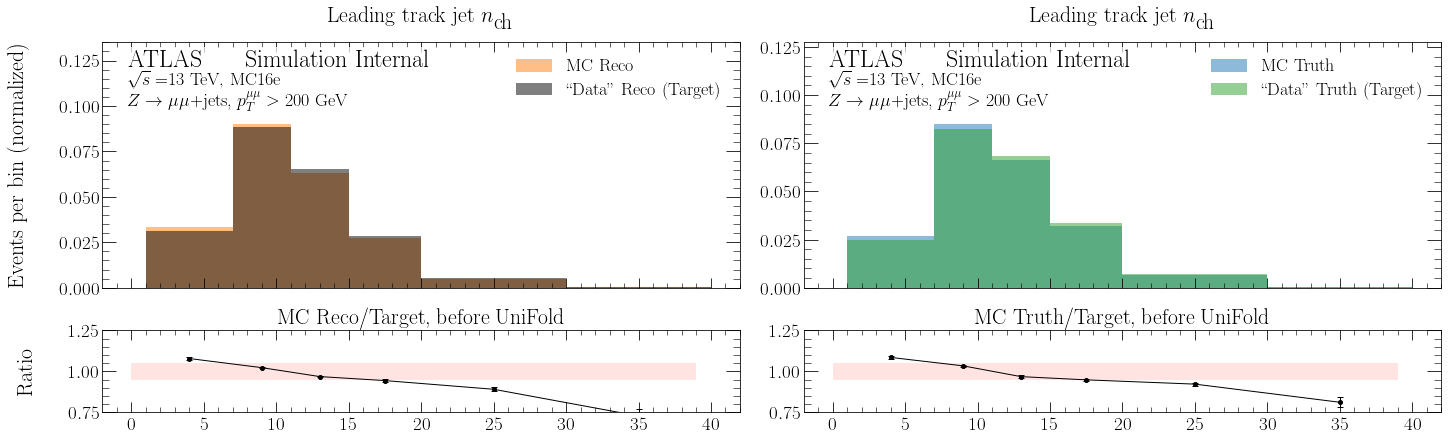

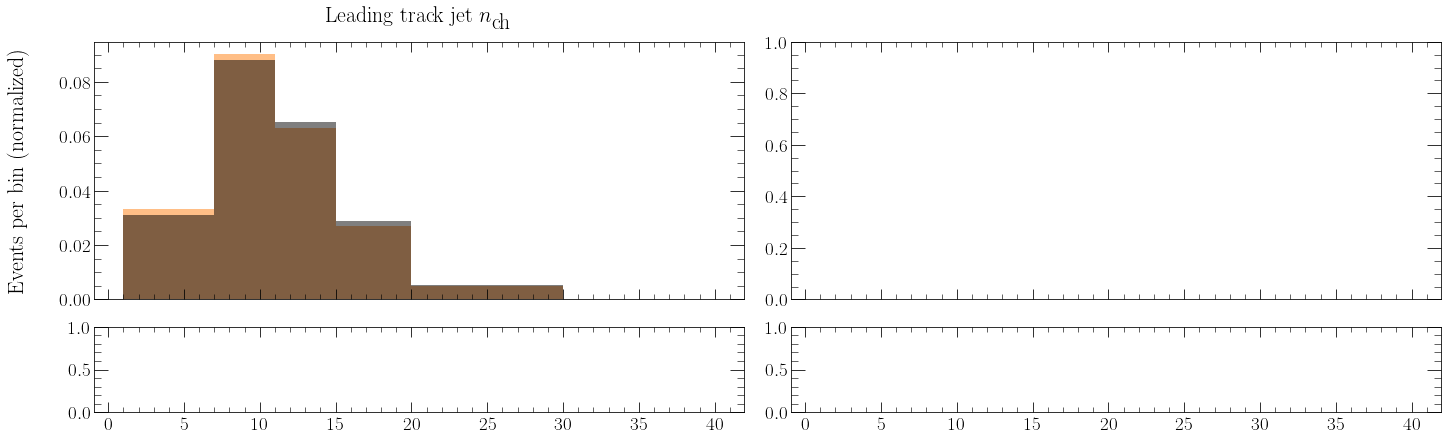

In [45]:
plot_results(sim_truth=mc_plots.truth_var,
             sim_reco=mc_plots.reco_var,
             sim_truth_weights_MC=mc_plots.weight_mc,
             sim_reco_weights_MC=mc_plots.weight,
             data_truth=data_truth_plots.truth_var,
             data_reco=data_plots.reco_var,
             data_truth_weights_MC=data_truth_plots.weight_mc,
             data_reco_weights_MC=data_plots.weight,
             weights=weights[:,:,filter],
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label
            )

# MultiFold

In [ ]:
K.clear_session()

In [ ]:
print("Unfolding {} variables.".format(len(ibu_hists)))

In [ ]:
mc_truth_plots = [None] * len(ibu_hists)
mc_reco_plots = [None] * len(ibu_hists)
data_truth_plots = [None] * len(ibu_hists)
data_reco_plots = [None] * len(ibu_hists)

mc_truth_hists = [None] * len(ibu_hists)
mc_reco_hists = [None] * len(ibu_hists)
data_truth_hists = [None] * len(ibu_hists)
data_reco_hists = [None] * len(ibu_hists)

# z-score standardization of data
sim_truth_z = [None] * len(ibu_hists)
sim_reco_z = [None] * len(ibu_hists)
data_reco_z = [None] * len(ibu_hists)

In [ ]:
for i in range(len(ibu_hists)):
    file_label = ibu_hists[i]['file_label']
    
    dummyval = -99
    
    ### Add in 200 GeV cuts for plotting only 
    mc_plots = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
    data_truth_plots = data_truth[data_truth.truth_pT_ll > 200]
    data_plots = data[data.pT_ll > 200]
    
    mc_truth_plots[i] = np.where(mc_plots.truth_pass190, mc_plots['truth_'+file_label], dummyval)
    mc_reco_plots[i] = np.where(mc_plots.pass190, mc_plots[file_label], dummyval)
    data_truth_plots[i] = data_truth_plots['truth_'+file_label]
    data_reco_plots[i] = data_plots[file_label]
    
    save_label0 = 'weight_truncation'
    bins = ibu_hists[i]['bins']
    x_label = ibu_hists[i]['plot_label']
    file_label = ibu_hists[i]['file_label']
    os.makedirs(plot_dir+'MultiFold/'+file_label, exist_ok=True)
    save_label = plot_dir+'MultiFold/'+file_label+'/'+save_label0
    print("Saving as {}.".format(save_label))

    plot_distributions(
        sim_truth=mc_truth_plots[i],
        sim_reco=mc_reco_plots[i],
        sim_truth_weights_MC=mc_plots.weight_mc,
        sim_reco_weights_MC=mc_plots.weight,
        data_truth=data_truth_plots[i],
        data_reco=data_reco_plots[i],
        data_truth_weights_MC=data_truth_plots.weight_mc,
        data_reco_weights_MC=data_plots.weight,
        bins=bins,
        x_label=x_label,
        save_label=save_label
    )
    
    mc_truth_hists[i] = np.where(mc.truth_pass190, mc['truth_'+file_label], dummyval)
    mc_reco_hists[i] = np.where(mc.pass190, mc[file_label], dummyval)
    data_truth_hists[i] = data_truth['truth_'+file_label]
    data_reco_hists[i] = data[file_label]
    
    sim_truth_z[i], sim_reco_z[i], data_reco_z[i] = standardize(
        np.array(mc_truth_hists[i]), 
        np.array(mc_reco_hists[i]), 
        np.array(data_reco_hists[i]))

In [ ]:
weights, _ = multifold(iterations=3,
                       sim_truth=sim_truth_z,
                       sim_reco=sim_reco_z,
                       sim_truth_weights_MC=mc.weight_mc,
                       sim_reco_weights_MC=mc.weight,
                       data_reco=data_reco_z,
                       data_reco_weights_MC=data.weight,
                       dummyval=dummyval,
                       verbose=0)

In [ ]:
for i in range(len(ibu_hists)):
    print(ibu_hists[i]['file_label'] + " Results\n")
    bins = ibu_hists[i]['bins']
    x_label = ibu_hists[i]['plot_label']
    file_label = ibu_hists[i]['file_label']
    save_label = plot_dir + '/MultiFold/' + file_label + '/' + save_label0 + '-MultiFold-' + file_label

    plot_results(sim_truth=sim_truth[i],
                 sim_reco=sim_reco[i],
                 sim_truth_weights_MC=mc.weight_mc,
                 sim_reco_weights_MC=mc.weight,
                 data_truth=data_truth[i],
                 data_reco=data_reco[i],
                 data_truth_weights_MC=data_truth.weight_mc,
                 data_reco_weights_MC=data.weight,
                 weights=weights,
                 bins=bins,
                 x_label=x_label,
                 flavor_label='MultiFold',
                 save_label=save_label)

In [ ]:
omnifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_plots))) # the right size for the 200 GeV cut